<a href="https://colab.research.google.com/github/ShokuninSan/deep-q-learning-from-paper-to-code/blob/master/11_cartpole_naive_deep_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch as T

In [0]:
%matplotlib inline

# Solving `CartPole` environment using a naive Deep Q-learning approach

## The `DQN`

In [0]:
class DQN(nn.Module):
    
    def __init__(self, n_input, n_hidden, n_classes,
                 loss=nn.MSELoss(),
                 optimizer=optim.Adam,
                 activation=lambda x: x,
                 lr=0.001):
        super(DQN, self).__init__()
        
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_classes)
        
        self.activation = activation
        self.loss = loss
        self.optimizer = optimizer(self.parameters(), lr=lr)       
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        fc1 = F.relu(self.fc1(state))
        fc2 = self.fc2(fc1)
        return fc2

### Test the DQN and approximate a binary AND operator

In [0]:
net = DQN(2, 4, 1, loss=nn.BCELoss(), optimizer=optim.Adam, lr=0.1, activation=T.sigmoid)

In [0]:
X = np.array([
    [1, 1],
    [0, 1],
    [0, 0],
    [1, 0]
]*100)

Y = [[1], [0], [0], [0]]*100

In [0]:
for x, y in zip(X, Y):
    net.optimizer.zero_grad()

    x_ = T.tensor(x, dtype=T.float).to(net.device)
    y_ = T.tensor(y, dtype=T.float).to(net.device)

    y_pred = net.activation(net.forward(x_))

    loss = net.loss(y_pred, y_)
    loss.backward()

    net.optimizer.step()

In [9]:
T.sigmoid(net.forward(T.tensor([1,1], dtype=T.float).to(net.device))).item()

0.9987175464630127

In [10]:
T.sigmoid(net.forward(T.tensor([0,0], dtype=T.float).to(net.device))).item()

3.8559175408181545e-08

In [11]:
T.sigmoid(net.forward(T.tensor([0,1], dtype=T.float).to(net.device))).item()

0.0009319333476014435

In [12]:
T.sigmoid(net.forward(T.tensor([1,0], dtype=T.float).to(net.device))).item()

0.0005140479188412428

## The `Agent`

Reuse the `Agent` implementation of the Q-learning example and substitute the dict by a `DQN`.

In [0]:
class Agent:

    def __init__(self, n_observations, n_actions, gamma=0.99, lr=0.001, epsilon=1.0, epsilon_dec=1e-5, epsilon_min=0.01):
        self.n_actions = n_actions
        self.n_observations = n_observations
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        self.Q = DQN(self.n_observations, 128, self.n_actions, lr=self.lr)

    def select_action(self, state):
        """
        Selects next action based on epsilon-greedy action selection.
        """
        action = None
        if np.random.rand() < self.epsilon:
            # do random action selection
            action = np.random.randint(self.n_actions)
        else:
            # do greedy action selection
            state = T.tensor(state, dtype=T.float).to(self.Q.device)
            action_values = self.Q.forward(state)
            action = T.argmax(action_values).item()

        return action
    
    def learn(self, state, action, reward, new_state):
        """
        Fits the DQN using the Bellman update equation and SGD.
        """
        self.Q.optimizer.zero_grad()        

        state = T.tensor(state, dtype=T.float).to(self.Q.device)
        action = T.tensor(action).to(self.Q.device)
        reward = T.tensor(reward).to(self.Q.device)
        new_state = T.tensor(new_state, dtype=T.float).to(self.Q.device)
        
        action_value = self.Q.forward(state)[action]
        next_action_value = self.Q.forward(new_state).max()
        expected_value = reward + self.gamma * next_action_value
        
        loss = self.Q.loss(expected_value, action_value).to(self.Q.device)
        loss.backward()
        self.Q.optimizer.step()
        self._decrement_epsilon()
        
    def _decrement_epsilon(self):
        """
        Decrements the epsilon for action selection.
        """
        self.epsilon = np.max([self.epsilon - self.epsilon_dec, self.epsilon_min])

In [0]:
N_EPISODES = 10_000

In [0]:
rewards = []
epsilons = []
avg_100_rewards = []
env = gym.make('CartPole-v1') #gym.make('FrozenLake-v0')

In [0]:
agent = Agent(n_observations=env.observation_space.shape[0], n_actions=env.action_space.n)

In [17]:
for episode in range(N_EPISODES):
    state = env.reset()
    is_done = False
    episode_reward = 0

    while not is_done:
        action = agent.select_action(state)
        new_state, reward, is_done, _ = env.step(action)
        agent.learn(state, action, reward, new_state)
        episode_reward += reward
        state = new_state
        
    rewards.append(episode_reward) 
    epsilons.append(agent.epsilon)

    if episode % 100 == 0:
        avg_reward = np.mean(rewards[-100:])
        avg_100_rewards.append(avg_reward)
        print(f'Average reward over last episodes was {avg_100_rewards[-1]}, epsilon: {agent.epsilon}')

Average reward over last episodes was 10.0, epsilon: 0.9999000000000005
Average reward over last episodes was 23.39, epsilon: 0.9765100000001069
Average reward over last episodes was 20.62, epsilon: 0.9558900000002007
Average reward over last episodes was 23.4, epsilon: 0.9324900000003072
Average reward over last episodes was 21.82, epsilon: 0.9106700000004065
Average reward over last episodes was 23.48, epsilon: 0.8871900000005134
Average reward over last episodes was 21.83, epsilon: 0.8653600000006128
Average reward over last episodes was 23.94, epsilon: 0.8414200000007217
Average reward over last episodes was 26.41, epsilon: 0.8150100000008419
Average reward over last episodes was 26.45, epsilon: 0.7885600000009623
Average reward over last episodes was 30.95, epsilon: 0.7576100000011031
Average reward over last episodes was 29.09, epsilon: 0.7285200000012355
Average reward over last episodes was 35.32, epsilon: 0.6932000000013963
Average reward over last episodes was 29.5, epsilon: 

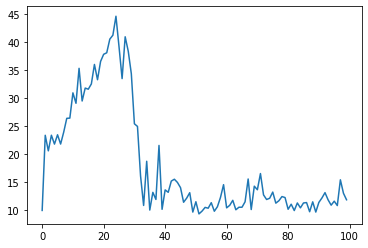

In [18]:
plt.plot(avg_100_rewards)

In [0]:
def plot_learning_curve(x, rewards, epsilons):
    fig = plt.figure()
    ax = fig.add_subplot(111, label='1')
    ax2 = fig.add_subplot(111, label='2', frame_on=False)
    
    ax.plot(x, epsilons, color='C0')
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Epsilon', color='C0')
    ax.tick_params(axis='y', colors='C0')
    
    N = len(rewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(rewards[max(0, t-100):(t+1)])
        
    ax2.plot(x, running_avg, color='C1')
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color='C1')
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors='C1')

In [0]:
x = list(range(1, N_EPISODES + 1))

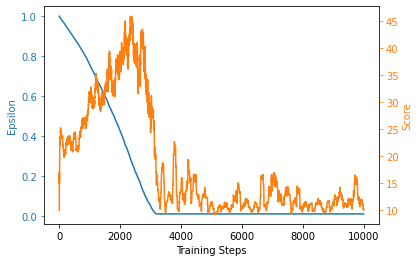

In [21]:
plot_learning_curve(x, rewards, epsilons)